# Explanaible AI - Partial Dependence - sklearn
Sklean offer a a method to calculate **partial dependence**. 

**It shoud be similar to the Permutation Importance offer by shap** (remember the partial depedence is the efect in the prediction changing the value of one feature while the rest of features are fixed in its mean values)

#### Link sklearn:
- Documentation code: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.partial_dependence.html#sklearn.inspection.partial_dependence
- User Guide: https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence
- Codes examples: https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py


#### Link sklearn:
Documentation code
- partial depedence: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.partial_dependence.html#sklearn.inspection.partial_dependence
- partial dependence plot: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.PartialDependenceDisplay.html#sklearn.inspection.PartialDependenceDisplay
- partial dependence plot from estimator: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.PartialDependenceDisplay.html#sklearn.inspection.PartialDependenceDisplay.from_estimator

User guide:
- unique: https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence

Codes examples:
- partial depende: https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py
- partial dependence plot: https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_partial_dependence_visualization_api.html#sphx-glr-auto-examples-miscellaneous-plot-partial-dependence-visualization-api-py
- partial dependence plot from estimator:

**Qué es PDP/ICE**

Se pueden utilizar gráficos de dependencia parcial (PDP) y gráficos de expectativas condicionales individuales (ICE) para visualizar y analizar la interacción entre la respuesta objetivo [1] y un conjunto de características de entrada de interés.

Tanto los PDP [H2009] como los ICE [G2015] suponen que las características de entrada de interés son independientes de las características del complemento, y este supuesto a menudo se viola en la práctica. Por lo tanto, en el caso de características correlacionadas, crearemos puntos de datos absurdos para calcular el PDP/ICE [M2019]

**Qué es PDP**

Los gráficos de dependencia parcial (PDP) muestran la dependencia entre la respuesta objetivo y un conjunto de características de entrada de interés, marginando los valores de todas las demás características de entrada (las características "complementarias"). Intuitivamente, podemos interpretar la dependencia parcial como la respuesta objetivo esperada en función de las características de entrada de interés.

Debido a los límites de la percepción humana, el tamaño del conjunto de características de entrada de interés debe ser pequeño (generalmente, una o dos), por lo que las características de entrada de interés generalmente se eligen entre las características más importantes.

**PDP one feature**

Las PDP unidireccionales nos informan sobre la interacción entre la respuesta objetivo y una característica de entrada de interés (por ejemplo, lineal, no lineal). 
Mostrar el efecto de una feature en los valores del target, y por ejemplo, que un valor alto de la feature se relaciona con un número alto del target

**PDP two features**
Los PDP con dos características de entrada de interés muestran las interacciones entre las dos características. Por ejemplo, mostrar la dependencia del target de los joint values de las features x1 y x2

**Consideration before calculate PDP**

Note that it is important to check that the model is accurate enough on a test set before plotting the partial dependence since there would be little use in explaining the impact of a given feature on the prediction function of a model with poor predictive performance

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sklearn

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

# data
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LinearRegression # lr
from sklearn.linear_model import Ridge # ridge
from sklearn.linear_model import Lasso # lasso
from sklearn.tree import DecisionTreeRegressor # tree
from sklearn.ensemble import GradientBoostingRegressor #gb
from sklearn.ensemble import RandomForestRegressor #rf
from xgboost import XGBRegressor # xgb
from  sklearn.neural_network import MLPRegressor # mlp

### 1. Load data

In [2]:
##### load data
data_X, data_y = fetch_california_housing(return_X_y=True, as_frame=True)

##### joinn and rename dataset
data = data_X.copy()
data['Price'] = data_y

##### dropduplicates - some kind of plots in plotly return error with duplicated values
data = data.drop_duplicates()

##### delete outliers
percentil_lower = data.quantile(0.01)
percentil_upper = data.quantile(0.99)

data_raw = data[(data >= percentil_lower) & (data <= percentil_upper)]
data_raw.dropna(inplace = True)


##### split into train/test
target = 'Price'
list_features = list(set(data_raw.columns) - set([target]))

X_train, X_test, y_train, y_test = train_test_split(data_raw[list_features], 
                                                    data_raw[[target]], 
                                                    test_size = 0.2, 
                                                    random_state=42
                                                   )

In [3]:
list_features

['HouseAge',
 'AveRooms',
 'Longitude',
 'AveOccup',
 'MedInc',
 'AveBedrms',
 'Latitude',
 'Population']

In [4]:
X_train.head()

,HouseAge,AveRooms,Longitude,AveOccup,MedInc,AveBedrms,Latitude,Population
5712,34.0,4.641509,-118.24,2.495957,4.1523,1.094340,34.22,926.0
15731,52.0,3.771250,-122.44,1.985000,3.3882,1.063750,37.78,1588.0
2894,38.0,4.135135,-118.99,3.346847,1.7292,0.990991,35.37,743.0
3333,13.0,4.770642,-122.62,2.284404,1.8417,1.055046,38.92,249.0
8410,33.0,3.636364,-118.35,4.721925,2.3375,1.026738,33.93,2649.0


### 2. Train models

#### 2.1 Linear regression

In [5]:
# train lr
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [6]:
# r2 score
r2_lr_train = lr.score(X_train, y_train)
r2_lr_test = lr.score(X_test, y_test)

print('r2_train: ', r2_lr_train)
print('r2_test: ', r2_lr_test)

r2_train:  0.6811276939092024
r2_test:  0.6813140626891637


#### 2.2 Random Forest Simple

In [7]:
# train rf simple
param_n_trees = 3
rf_simple = RandomForestRegressor(n_estimators = param_n_trees,
                                  random_state = 42,
                                 min_samples_split = 0.2,
                                    min_samples_leaf = 0.1)
                                   #max_depth = 2)
rf_simple.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=0.1, min_samples_split=0.2,
                      n_estimators=3, random_state=42)

In [8]:
# r2 score
r2_rf_simple_train = rf_simple.score(X_train, y_train)
r2_rf_simple_test = rf_simple.score(X_test, y_test)

print('r2_train: ', r2_rf_simple_train)
print('r2_test: ', r2_rf_simple_test)

r2_train:  0.45686524868931044
r2_test:  0.43402741471810513


#### 2.3 Random Forest Default

In [9]:
# train rf default hiperparameters
rf_default = RandomForestRegressor(random_state = 42)
rf_default.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [10]:
# r2 score
r2_rf_default_train = rf_default.score(X_train, y_train)
r2_rf_default_test = rf_default.score(X_test, y_test)

print('r2_train: ', r2_rf_default_train)
print('r2_test: ', r2_rf_default_test)

r2_train:  0.9742259623610241
r2_test:  0.8102260883963007


### 3 Partial Dependence Plot - Manually - Intuition
El gráfico muestra cómo cambia la predicción del modelo en función de un conjunto específico de features, mientras se mantienen todas las demás características constantes en su valor promedio.

Mine calculations

In [11]:
def scatter_partial_dependence_plot(feature, X, model):
    """
    Plot mine scatter plot of partial dependence plot.

    Plot how changing the predicton of a model in a function of the values of a specific feature while the rest of features not changing and
    are fixed in its mean values

    Args
        feature (string): feature to plot the partial dependence plot
        X (dataframe): dataframe of features - X
        model (model): model

    Return
        fig (figure matplotlib): figure with scatter plot of pdp of a feature
    """

    ############################## define list of features ##############################
    # list feature
    list_features = X.columns.tolist()
    print('list features: ', list_features)
    
    # calculate feature to calculate mean values
    list_features_mean = list(set(list_features) - set([feature]))
    print('list features to calculate mean: ', list_features_mean)
    
    
    ############################## generate dataframe X_pdp ##############################
    # calculate mean values - all features
    X_mean = X.mean()
    
    # get values of feature to pdp
    X_pdp = X[[feature]]
    
    
    # generate data to partial dependence plot with the mean values of all features except to feature to plot pdp
    for feature_mean in list_features_mean:
        #print('adding mean value feature: ', feature_mean)
        
        # calculate dataframe to pdp
        X_pdp[feature_mean] = X_mean[feature_mean]
    
    # sort values
    X_pdp = X_pdp[list_features]
    
    
    ############################## predict with data pdp ##############################
    # predict with mean values the rest of features
    y_pred_pdp = model.predict(X_pdp)
    
    
    ############################## plot scatter pdp ##############################
    fig = plt.figure()
    plt.scatter(x = X_pdp[feature], 
                y = y_pred_pdp, 
                marker = 'x')
    
    return fig

list features:  ['HouseAge', 'AveRooms', 'Longitude', 'AveOccup', 'MedInc', 'AveBedrms', 'Latitude', 'Population']
list features to calculate mean:  ['HouseAge', 'Longitude', 'AveRooms', 'AveOccup', 'AveBedrms', 'Latitude', 'Population']


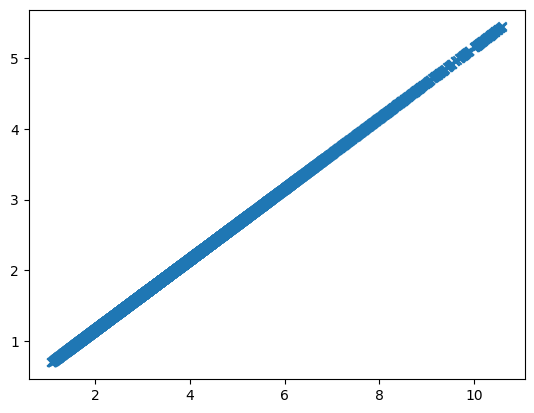

In [12]:
feature_pdp = 'MedInc'
fig_pdp_mine_lr = scatter_partial_dependence_plot(feature = feature_pdp,
                                                  X = X_train,
                                                  model = lr
                                                 )

### 4. PDP - sklearn - one feature - using function "partial_depende" and "PartialDependenceDisplay"

Plot calculating using "partial_dependence" and then plotting using "PartialDependenceDisplay"

#### sklearn.inspection.partial_dependence

Output:
- **individual**: The predictions for all the points in the grid for all samples in X. This is also known as Individual Conditional Expectation (ICE). Only available when kind='individual' or kind='both'.
  
- **average**: 
The predictions for all the points in the grid, averaged over all samples in 
  
- **values**: 
The values with which the grid has been created
  
- **grid_values**: 
The values with which the grid has been created. The generated grid is a cartesian product of the arrays in grid_values where len(grid_values) == len(features). The size of each array grid_values[j] is either grid_resolution, or the number of unique values in X[:, j], whichever is smaller


#### sklearn.inspection.PartialDependenceDisplay....

In [13]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

In [14]:
##########  define feature to plot ##########
feature_pdp = ['MedInc']
feature_pdp

['MedInc']

In [15]:
list_features

['HouseAge',
 'AveRooms',
 'Longitude',
 'AveOccup',
 'MedInc',
 'AveBedrms',
 'Latitude',
 'Population']

In [16]:
##########  get values using partial_dependence ##########
results_pd = partial_dependence(lr,
                                 features = feature_pdp, 
                                 X = X_train, 
                    percentiles = (0, 1), #The lower and upper percentile used to create the extreme values for the grid. Must be in [0, 1],
                    grid_resolution = 3, # The number of equally spaced points on the grid, for each target feature.,
                    kind = 'average'
                  )

In [17]:
results_pd

{'grid_values': [array([ 1.0714 ,  5.83275, 10.5941 ])],
 'values': [array([ 1.0714 ,  5.83275, 10.5941 ])],
 'average': array([[0.69810906, 3.07329464, 5.44848022]])}

In [18]:
# see that the values used to calculate the pdp were getting from min_value to max_value in the data
X_train[feature_pdp].describe()

,MedInc
count,14540.000000
mean,3.888150
std,1.663276
min,1.071400
25%,2.659625
50%,3.612650
75%,4.801400
max,10.594100


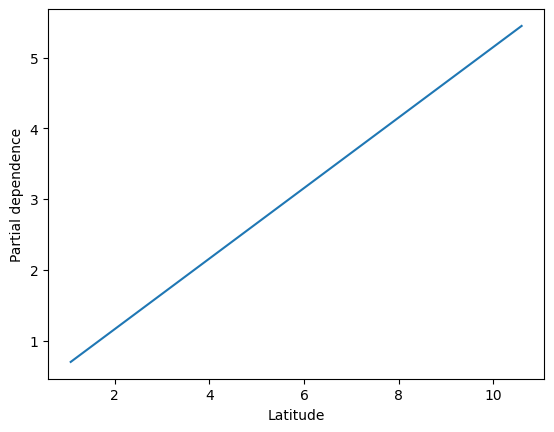

In [19]:
##########  plot partial_dependence ########## - try list of tuples - all features

deciles = {0: np.linspace(0, 1, num=3)}

display = PartialDependenceDisplay(
    [results_pd], 
    features = [(6,)], # index of the feature in list_features to show in X-axis. See the calcuation of partial dependence not return the feature
    feature_names = list_features,
    target_idx = 0, 
    deciles=deciles
)
display.plot()
plt.show()

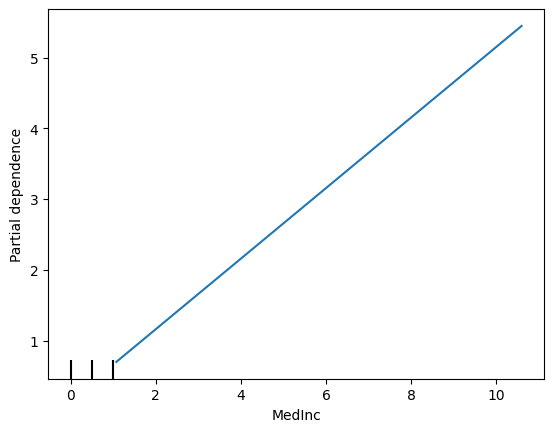

In [20]:
##########  plot partial_dependence ########## - try list of tuples - only list feature_pdp 

deciles = {0: np.linspace(0, 1, num=3)}

display = PartialDependenceDisplay(
    [results_pd], 
    features = [(0,)], # index of the feature in list_features to show in X-axis. See the calcuation of partial dependence not return the feature
    feature_names = feature_pdp,
    target_idx = 0, 
    deciles=deciles
)
display.plot()
plt.show()

# en el gráfico se ve raro el eje X

**Obs:**
- Primer se utiliza la función "partial_dependence" para obtener los partial dependence de una feature en concreto. Esta función retorna los valores de la feature analizada (valores del eje X) y los valores predichos del target (valores para mostrar en eje Y). Además se retornan otros valores pero no interesan.
  
- Sin embargo, la función no retorna a qué feature se hizo el cálculo
  
- Luego para hacer el plot se utiliza la función "PartialDependenceDisplay" en el cual se pasa el output de "partial_dependence" además que se necesita indicar el nombre del eje X en el plot (la feature calculada). Además que se necesita indicar dos parámetros obligatorios que son innecesario y hacen **COTRAINTUITIVO graficar pdp así.**
  
- **Utilizar esta metodología (tener una función para calcular dependencia partial) y luego con el resultado graficar el partial dependence plot solo es útil cuando se quiere tener los valores de dependencia partial además del plot**

### 5. PDP - sklearn - one feature - using function "partial_depende" and "PartialDependenceDisplay.from_estimator"

Using directly the function

In [21]:
feature_pdp

['MedInc']

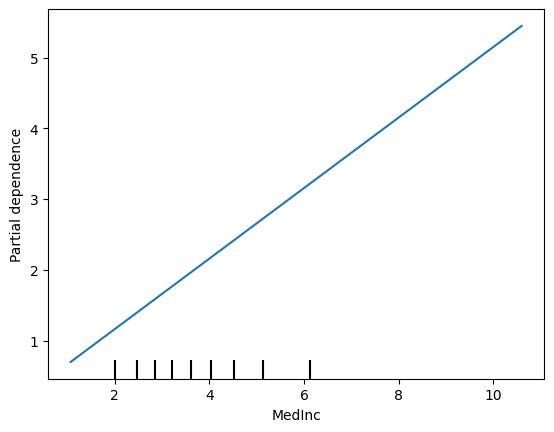

In [22]:
##### PPLOT sin calcular aparte partial dependence - usar metodo .from_estimator
display = PartialDependenceDisplay.from_estimator(
    estimator = lr,
    X = X_train,
    features = feature_pdp, ## IMPORANT TO INDICATE WHICH FEATURE TO PLOT IT IS NECCESARY DEFINE IT IN A LIST. list of {int, str, pair of int, pair of str}
    n_cols = 3,  ## number of columns max in the subplot - plot PDP multiple features
    grid_resolution = 100, # The number of equally spaced points on the axes of the plots
    percentiles = (0, 1) # The lower and upper percentile used to create the extreme values for the PDP axes. default (0.05, 0.95)
)

### 6. PDP - sklearn - multiple - features - "PartialDependenceDisplay.from_estimator"

In [23]:
X_train.head()

,HouseAge,AveRooms,Longitude,AveOccup,MedInc,AveBedrms,Latitude,Population
5712,34.0,4.641509,-118.24,2.495957,4.1523,1.094340,34.22,926.0
15731,52.0,3.771250,-122.44,1.985000,3.3882,1.063750,37.78,1588.0
2894,38.0,4.135135,-118.99,3.346847,1.7292,0.990991,35.37,743.0
3333,13.0,4.770642,-122.62,2.284404,1.8417,1.055046,38.92,249.0
8410,33.0,3.636364,-118.35,4.721925,2.3375,1.026738,33.93,2649.0


In [24]:
y_train.head()

,Price
5712,2.520
15731,4.714
2894,0.581
3333,0.847
8410,1.706


In [25]:
list_features

['HouseAge',
 'AveRooms',
 'Longitude',
 'AveOccup',
 'MedInc',
 'AveBedrms',
 'Latitude',
 'Population']

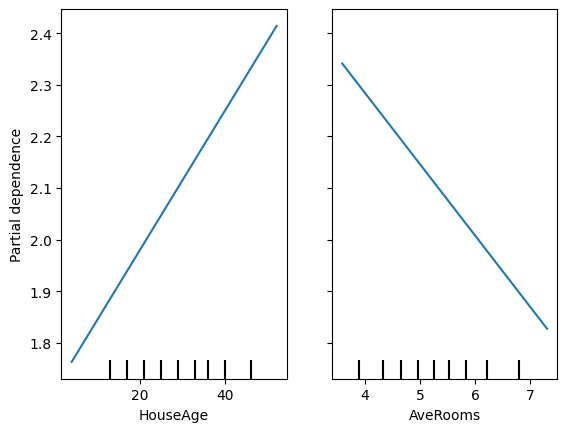

In [26]:
# PDP - two features
display = PartialDependenceDisplay.from_estimator(
    estimator  = lr,
    X = X_train,
    random_state = 42,
    features = list_features[0:2]
)

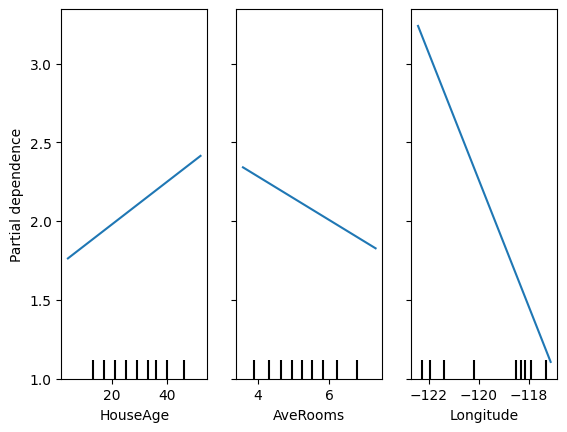

In [27]:
# PDP - three features
display = PartialDependenceDisplay.from_estimator(
    estimator = lr,
    X = X_train,
    random_state = 42,
    features = list_features[0:3]
)

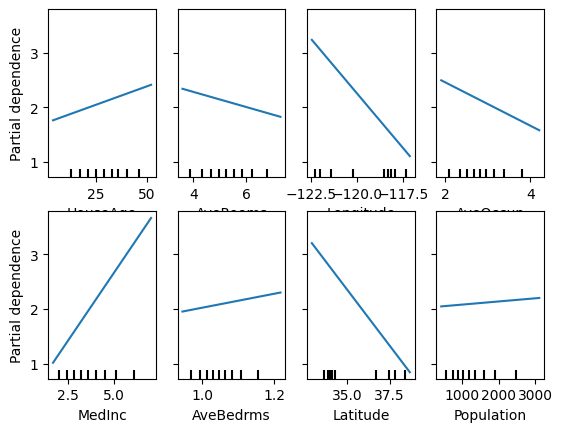

In [28]:
# PDP - all features
display = PartialDependenceDisplay.from_estimator(
    estimator = lr,
    X = X_train,
    random_state = 42,
    features = list_features,
    n_cols = 4
)

### 7. PDP - sklearn - combined effect two features

In [29]:
# define a tuple of two features to plot the combined PDP of its features
# REMEMBER to pass which feature to plot PDP it is necessary pass the values in a list, so it is necesary define a list of tuple
two_features_pdp = [("MedInc", "HouseAge")]
two_features_pdp

[('MedInc', 'HouseAge')]

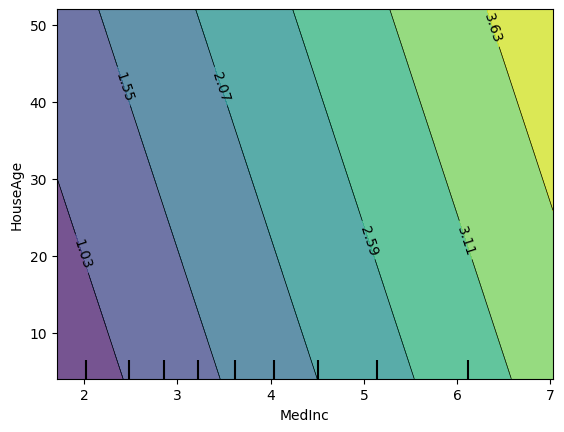

In [32]:
# PDP - effect combined 2 features
display = PartialDependenceDisplay.from_estimator(
    estimator = lr,
    X = X_train,
    features = two_features_pdp
)

### 8. PDP - multiple plots - individial PDP and two-way PDP
Plot individual pdp of two features, and then, plot the combined effect pdp of its two features

In [33]:
# define differents pdp to plot
feature_1_pdp = "MedInc"
feature_2_pdp = "HouseAge"
feature_1_2_pdp = ("MedInc", "HouseAge")

# generate a list of differents pdp to plot
list_pdp_to_plot = [feature_1_pdp, feature_2_pdp, feature_1_2_pdp]
list_pdp_to_plot

['MedInc', 'HouseAge', ('MedInc', 'HouseAge')]

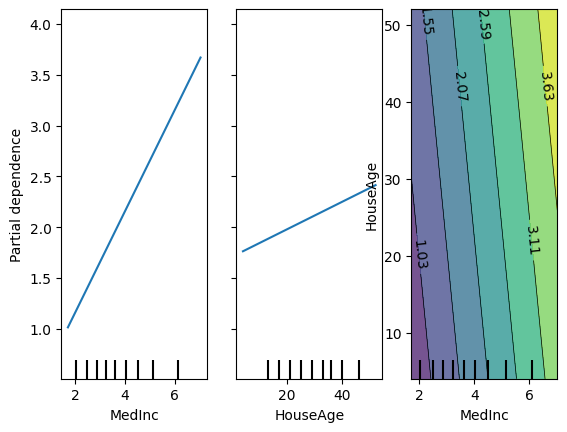

In [34]:
# PDP
display = PartialDependenceDisplay.from_estimator(
    estimator = lr,
    X = X_train,
    features = list_pdp_to_plot
)